# Aula 4 de Aprendizado de M√°quina e Reconhecimento de Padr√µes

Prof. Dr. Rodrigo Colnago Contreras

contreras@unifesp.br



## Programa

- Introdu√ß√£o
- SVM com margem r√≠gida
- SVM com margem suave
- SVM com kernel
- SVM para regress√£o
- Exerc√≠cios Resolvidos


# Introdu√ß√£o √†s *Support Vector Machines* (SVMs)

As *Support Vector Machines* (SVMs) s√£o modelos amplamente utilizados em tarefas de classifica√ß√£o e regress√£o. Elas fazem parte da **Teoria do Aprendizado Estat√≠stico**, formalizada por Vapnik e Chervonenkis, e s√£o particularmente poderosas quando trabalhamos com conjuntos de dados de alta dimens√£o e fronteiras complexas.

A ideia central das SVMs √© encontrar um **hiperplano √≥timo de separa√ß√£o** entre exemplos de classes distintas, ou seja, aquele que **maximiza a margem** entre os exemplos de diferentes categorias. A margem √© a dist√¢ncia entre o hiperplano e os pontos mais pr√≥ximos de cada classe ‚Äî os chamados **vetores de suporte**.

Nesta aula, come√ßaremos com a intui√ß√£o geom√©trica das SVMs e, em seguida, evoluiremos para a formula√ß√£o matem√°tica da **SVM com margens r√≠gidas**.

Abaixo, visualizamos um exemplo did√°tico onde temos duas classes linearmente separ√°veis. A linha tracejada preta representa um poss√≠vel hiperplano de separa√ß√£o. As linhas verdes representam as margens ‚Äî e nossa meta ser√° encontrar o hiperplano que as **maximiza**.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Gerar dados simulados para duas classes linearmente separ√°veis
np.random.seed(1)
X_class1 = np.random.randn(10, 2) + [2, 2]
X_class2 = np.random.randn(10, 2) + [-2, -2]
X = np.vstack((X_class1, X_class2))
y = np.hstack((np.ones(10), -1*np.ones(10)))

# Definir vetor w e b para uma "reta separadora" simulada
w = np.array([1, 1])
b = 0

# Fun√ß√£o para plotar o gr√°fico
def plot_svm_margin(X, y, w, b):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Classe +1')
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Classe -1')

    # Criar linha de separa√ß√£o e margens
    x_vals = np.linspace(-5, 10, 100)
    y_vals = -(w[0] * x_vals + b) / w[1]
    margin = 1 / np.linalg.norm(w)
    y_vals_margin1 = y_vals + margin
    y_vals_margin2 = y_vals - margin

    plt.plot(x_vals, y_vals, 'k--', label='Hiperplano de separa√ß√£o')
    plt.plot(x_vals, y_vals_margin1, 'g--', label='Margem +1')
    plt.plot(x_vals, y_vals_margin2, 'g--', label='Margem -1')

    plt.title("Separa√ß√£o com Margens: Intui√ß√£o das SVMs")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.grid(True)
    plt.xlim(-5, 10)
    plt.ylim(-5, 5)
    plt.show()

plot_svm_margin(X, y, w, b)


# SVMs com Margens R√≠gidas

Vamos come√ßar definindo o problema de **classifica√ß√£o bin√°ria supervisionada**.

Seja um conjunto de treinamento com $n$ exemplos, onde cada exemplo √© composto por um vetor de atributos $\mathbf{x}_i =(x_{i,1},x_{i,2},...,x_{i,d}) \in \mathbb{R}^d$ e um r√≥tulo associado $y_i \in \{-1, +1\}$:

$$
\mathcal{D} = \{ (\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), \dots, (\mathbf{x}_n, y_n) \}.
$$

Nosso objetivo √© encontrar uma fun√ß√£o $h(\mathbf{x})$ que separe corretamente os exemplos positivos dos negativos.

A SVM assume que os dados s√£o **linearmente separ√°veis**, ou seja, existe um **hiperplano** definido por um vetor normal $\mathbf{w} = (w_1,w_2,...,w_d) \in \mathbb{R}^d$ e um escalar $b \in \mathbb{R}$ tal que:

$$
h(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b,
$$

e que todos os pontos do conjunto de dados satisfa√ßam a condi√ß√£o:

$$
y_i (\mathbf{w}^\top \mathbf{x}_i + b) > 0 \quad \forall i = 1, \dots, n
$$



**Obs.:** Esse hiperplano pode ser utilizado para separar o espa√ßo de entrada em dois conjuntos: aqueles formados pelos vetores $\mathbf{x}$ tais que $ h(\mathbf{x}) \geq 0$ e pelos que n√£o satisfazem a √∫ltima inequa√ß√£o. Em outras palavras, dado um vetor $\mathbf{x}$ qualquer, podemos estimar seu r√≥tulo $\mathbf{y}$ pela fun√ß√£o $\text{sinal}(\cdot)$ definida na sequ√™ncia:


$$
\mathrm{sinal}(h(\mathbf{x})) =
\begin{cases}
+1, & \text{se } \mathbf{w}^\top \mathbf{x} + b \geq 0, \\
-1, & \text{se } \mathbf{w}^\top \mathbf{x} + b < 0. \\
\end{cases}
$$

## Exemplo: Classifica√ß√£o com $\mathrm{sign}(h(\mathbf{x}))$

Vamos ilustrar como a fun√ß√£o $\mathrm{sign}(h(\mathbf{x}))$ atua na pr√°tica para classificar exemplos de duas classes linearmente separ√°veis.

Neste exemplo:

- Geramos duas nuvens de pontos em $\mathbb{R}^2$, uma de classe $+1$ (azul) e outra de classe $-1$ (vermelha);
- Utilizamos um hiperplano arbitr√°rio $h(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b$ com $\mathbf{w} = [1, 1]$ e $b = 0$;
- Classificamos os pontos com $\hat{y} = \mathrm{sign}(h(\mathbf{x}))$.




In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Gerar dados de duas classes linearmente separ√°veis
np.random.seed(42)
X_pos = np.random.randn(10, 2) + [2, 2]
X_neg = np.random.randn(10, 2) + [-2, -2]
X = np.vstack((X_pos, X_neg))
y = np.hstack((np.ones(10), -1*np.ones(10)))

# Definir hiperplano w e b arbitr√°rios (corretamente separando as classes)
w = np.array([1, 1])
b = 0

# Classifica√ß√£o usando sign(h(x))
def classify(X, w, b):
    h_x = np.dot(X, w) + b
    return np.sign(h_x)

y_pred = classify(X, w, b)

# Visualiza√ß√£o
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Classe verdadeira +1')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Classe verdadeira -1')

# Marcar classifica√ß√µes corretas/incorretas
for i in range(len(X)):
    if y[i] == y_pred[i]:
        plt.plot(X[i, 0], X[i, 1], 'go', markersize=10, fillstyle='none')  # correto
    else:
        plt.plot(X[i, 0], X[i, 1], 'kx', markersize=10)  # incorreto

# Desenhar o hiperplano
x_vals = np.linspace(-5, 5, 100)
y_vals = -(w[0] * x_vals + b) / w[1]
plt.plot(x_vals, y_vals, 'k--', label='Hiperplano: $h(\\mathbf{x})=0$')

plt.title("Classifica√ß√£o com $\mathrm{sign}(h(\\mathbf{x}))$")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()


## Infinitos Hiperplanos e o Hiperplano Can√¥nico

Quando os dados s√£o **linearmente separ√°veis**, existem **infinitos hiperplanos** que conseguem separar perfeitamente as duas classes. Isso porque a separa√ß√£o pode ser feita com diferentes inclina√ß√µes e dist√¢ncias em rela√ß√£o aos pontos, ainda mantendo a separabilidade.

No entanto, **nem todos esses hiperplanos s√£o igualmente bons**. Um hiperplano que passe muito pr√≥ximo dos pontos de treinamento pode ter baixa capacidade de generaliza√ß√£o. Por isso, buscamos o **hiperplano √≥timo**, aquele que **maximiza a margem de separa√ß√£o** entre as classes.

Para formalizar essa busca, introduzimos o conceito de **hiperplano can√¥nico**.

### Defini√ß√£o: Hiperplano Can√¥nico

Chamamos de **hiperplano can√¥nico** aquele para o qual os exemplos mais pr√≥ximos entre si de cada classe, tamb√©m conhecidos como ***vetores de suporte***, satisfazem:

$$
|h(\mathbf{x}_i)| = |\mathbf{w}^\top \mathbf{x}_i + b| = 1,
$$

ou, de forma equivalente:

$$
y_i(\mathbf{w}^\top \mathbf{x}_i + b) = 1.
$$

Esse valor fixado de 1 para o funcional de decis√£o dos vetores de suporte **define a escala da margem** e nos permite transformar o problema de separa√ß√£o √≥tima em um problema de **minimiza√ß√£o convexa**.

√â importante notar que **essa igualdade vale apenas para os vetores de suporte** ‚Äî isto √©, os pontos de treinamento que est√£o exatamente sobre as margens. Para os demais exemplos do conjunto de dados (aqueles mais distantes do hiperplano), temos:

$$
y_i(\mathbf{w}^\top \mathbf{x}_i + b) > 1.
$$

Portanto, o conjunto de restri√ß√µes da SVM com margens r√≠gidas √© descrito pelas seguintes **inequa√ß√µes**:

$$
y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1 \quad \text{para todo } i = 1, \dots, n.
$$



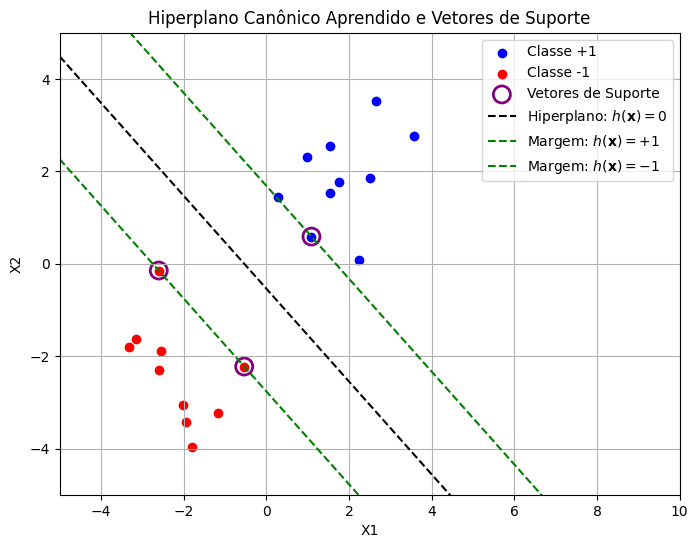

In [3]:
# Obter os coeficientes do hiperplano
w = np.array([0.45182465, 0.4494984 ])
b = 0.24209387304919786

# Identificar vetores de suporte
support_vectors = np.array([[-0.53435123, -2.2257763 ],
                          [-2.60170661, -0.14772182],
                          [ 1.09197592,  0.5876963 ]])

# Visualiza√ß√£o
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Classe +1')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Classe -1')

# Destacar vetores de suporte
plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
            s=150, facecolors='none', edgecolors='purple', linewidths=2, label='Vetores de Suporte')

# Gerar pontos para o gr√°fico do hiperplano e margens
x_vals = np.linspace(-5, 10, 200)
y_vals = -(w[0] * x_vals + b) / w[1]
y_margin_plus = -(w[0] * x_vals + b - 1) / w[1]
y_margin_minus = -(w[0] * x_vals + b + 1) / w[1]

# Plotar hiperplano e margens can√¥nicas
plt.plot(x_vals, y_vals, 'k--', label='Hiperplano: $h(\\mathbf{x})=0$')
plt.plot(x_vals, y_margin_plus, 'g--', label='Margem: $h(\\mathbf{x})=+1$')
plt.plot(x_vals, y_margin_minus, 'g--', label='Margem: $h(\\mathbf{x})=-1$')

plt.title("Hiperplano Can√¥nico Aprendido e Vetores de Suporte")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.xlim(-5, 10)
plt.ylim(-5, 5)
plt.show()


## Qual √© a dist√¢ncia entre os dois hiperplanos can√¥nicos?

Seja $h(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b$ o hiperplano de decis√£o.

A **dist√¢ncia de um ponto $\mathbf{x}$ ao hiperplano $h(\mathbf{x})=\mathbf{w}\mathbf{x}+b = 0$** √© dada por:

$$
\text{dist√¢ncia}(\mathbf{x}, h) = \frac{|\mathbf{w}^\top \mathbf{x} + b|}{\|\mathbf{w}\|}.
$$

Como estamos trabalhando com o **hiperplano can√¥nico**, sabemos que os vetores de suporte $\mathbf{x}_i$ (os pontos mais pr√≥ximos do hiperplano de decis√£o) satisfazem:

$$
|h(\mathbf{x}_i)| = |\mathbf{w}^\top \mathbf{x}_i + b| = 1.
$$

Portanto, a dist√¢ncia de um vetor de suporte ao hiperplano √©:

$$
\text{dist√¢ncia}(\mathbf{x}, h) = \frac{|\mathbf{w}^\top \mathbf{x} + b|}{\|\mathbf{w}\|} = \frac{|1|}{\|\mathbf{w}\|} = \frac{1}{\|\mathbf{w}\|}.
$$

Como temos **dois vetores de suporte**, um de cada classe (um em cada lado do hiperplano), e ambos est√£o a essa mesma dist√¢ncia do hiperplano, a **dist√¢ncia total** entre estes representantes de cada uma das duas classes √© o dobro disso:

$$
\text{dist√¢ncia entre os hiperplanos can√¥nicos} = \frac{1}{\|\mathbf{w}\|} + \frac{1}{\|\mathbf{w}\|} = \frac{2}{\|\mathbf{w}\|}.
$$

---

**Obs.:** Chamamos a dist√¢ncia entre os hiperplanos can√¥nicos de ***margem***.

---

**Conclus√£o:** Observe que quanto maior a dist√¢ncia entre os hiperplanos $\dfrac{2}{\|\mathbf{w}\|}$ menor √© o valor de **$\|\mathbf{w}\|$**. Ent√£o, maximizar a dist√¢ncia entre as classes pelo hiperplano linear √© equivalente a minimizar a norma de seu vetor normal $\mathbf{w}$. Ou ainda, mais convenientemente, **minimizar $\dfrac{1}{2}\|\mathbf{w}\|^2$** para tornar o problema mais trat√°vel numericamente.


In [4]:
# Calcular vetor unit√°rio perpendicular (dire√ß√£o da margem)
norm_w = np.linalg.norm(w)
u_w = w / norm_w

x0_shifted = np.array([2.5, -(w[0] * 2.5 + b) / w[1]])  # ponto sobre o hiperplano h(x)=0

# Calcular deslocamento perpendicular para as margens
p1 = x0_shifted + (1 / norm_w) * u_w
p2 = x0_shifted - (1 / norm_w) * u_w
mid_point = (p1 + p2) / 2

# Replotar
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Classe +1')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Classe -1')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
            s=150, facecolors='none', edgecolors='purple', linewidths=2, label='Vetores de Suporte')

# Hiperplanos
plt.plot(x_vals, y_vals, 'k--', label='Hiperplano: $h(\\mathbf{x})=0$')
plt.plot(x_vals, y_margin_plus, 'g--', label='Margem: $h(\\mathbf{x})=+1$')
plt.plot(x_vals, y_margin_minus, 'g--', label='Margem: $h(\\mathbf{x})=-1$')

# Desenhar seta da margem mais acima
plt.annotate('', xy=p1, xytext=p2,
             arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
plt.text(mid_point[0] + 0.3, mid_point[1],
         r'Margem $=\dfrac{2}{\|\mathbf{w}\|}$', fontsize=12, verticalalignment='center')

plt.title("Margem Perpendicular entre os Hiperplanos Can√¥nicos (Anotada Acima)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.xlim(-5, 10)
plt.ylim(-5, 5)
plt.show()


## Conclus√£o: Formulando o Problema de Otimiza√ß√£o das SVMs

A partir da geometria observada, conclu√≠mos que:

- A **largura da margem** entre os hiperplanos can√¥nicos √© dada por $\dfrac{2}{\|\mathbf{w}\|}$;
- Para **maximizar a separa√ß√£o entre as classes**, precisamos **maximizar essa margem**;
- Isso √© equivalente a **minimizar $\frac{1}{2}\|\mathbf{w}\|^2$**.

Al√©m disso, para garantir que todos os exemplos estejam **fora ou sobre as margens**, impomos as **restri√ß√µes can√¥nicas**:

$$
y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1, \quad \text{para } i = 1, \dots, n.
$$

Com isso, podemos formular o problema de **otimiza√ß√£o primal da SVM com margens r√≠gidas** como:

$$
\begin{aligned}
\min_{\mathbf{w}, b} \quad & \frac{1}{2} \|\mathbf{w}\|^2, \\
\text{sujeito a} \quad & y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1, \quad \forall i=1,2,...,n.
\end{aligned}
$$

Este √© um **problema de otimiza√ß√£o convexa com restri√ß√µes lineares**, e sua solu√ß√£o nos fornece o **hiperplano √≥timo de separa√ß√£o** com **a maior margem poss√≠vel entre as classes**.


## Como Resolver o Problema de Otimiza√ß√£o na Pr√°tica?

O problema primal das SVMs com margens r√≠gidas √© um exemplo cl√°ssico de **programa√ß√£o convexa com restri√ß√µes lineares**. Ele pode ser resolvido eficientemente por diversos **pacotes de otimiza√ß√£o matem√°tica** que implementam m√©todos como gradiente projetado, m√©todos de barreira ou algoritmos do tipo SMO.

A seguir, listamos algumas op√ß√µes dispon√≠veis em Python para resolver esse tipo de problema:

### üõ†Ô∏è Pacotes e Ferramentas:

- **`cvxpy`**: biblioteca de modelagem de otimiza√ß√£o convexa extremamente flex√≠vel.
  ```python
  import cvxpy as cp
  w = cp.Variable(n)
  b = cp.Variable()
  objective = cp.Minimize(0.5 * cp.norm(w, 2)**2)
  constraints = [y[i] * (X[i] @ w + b) >= 1 for i in range(n)]
  problem = cp.Problem(objective, constraints)
  problem.solve()


In [5]:
import numpy as np
import cvxpy as cp

# Reutilizar X e y definidos anteriormente
n_samples, n_features = X.shape

# Vari√°veis de otimiza√ß√£o
w = cp.Variable(n_features)
b = cp.Variable()

# Fun√ß√£o objetivo
objective = cp.Minimize(0.5 * cp.norm(w, 2)**2)

# Restri√ß√µes
constraints = [y[i] * (X[i] @ w + b) >= 1 for i in range(n_samples)]

# Problema de otimiza√ß√£o
problem = cp.Problem(objective, constraints)
problem.solve()

# Solu√ß√£o
print("w √≥timo:", w.value)
print("b √≥timo:", b.value)
print("Margem: ", 2 / np.linalg.norm(w.value))


w √≥timo: [0.4519453  0.44961841]
b √≥timo: 0.24224753250404676
Margem:  3.137235511281764


# SVM com Margens Suaves (Soft Margin)

Na pr√°tica, nem sempre √© poss√≠vel encontrar um hiperplano que separe perfeitamente os dados. Isso pode ocorrer por:

- **Ru√≠do** ou **outliers** no conjunto de treinamento;
- Dados que **n√£o s√£o linearmente separ√°veis**;
- Interesse em permitir certa **flexibilidade** na separa√ß√£o, para melhorar a generaliza√ß√£o.

Para lidar com esses casos, introduzimos a **SVM com margens suaves**, que permite **viola√ß√µes controladas das margens** por meio de vari√°veis de folga $\xi_i \geq 0$ para cada exemplo.

### Modifica√ß√£o do problema de otimiza√ß√£o

A ideia √© permitir que alguns exemplos **violem a margem ou at√© mesmo o lado correto do hiperplano**, mas penalizando essas viola√ß√µes na fun√ß√£o objetivo. O problema de otimiza√ß√£o passa a ser:

$$
\begin{aligned}
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \quad & \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \xi_i \\
\text{sujeito a} \quad & y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1 - \xi_i, \quad \forall i = 1,2,...,n, \\
& \xi_i \geq 0, \quad \forall i = 1,2,...,n.
\end{aligned}
$$

- As **vari√°veis $\xi_i$** quantificam quanto o exemplo $i$ **viola a margem** (ou o lado certo do hiperplano);
- O par√¢metro **$C > 0$** controla o *trade-off* entre **maximizar a margem** e **minimizar as viola√ß√µes**:
  - $C$ grande ‚Üí penaliza fortemente viola√ß√µes ‚Üí tende a se comportar como margem r√≠gida;
  - $C$ pequeno ‚Üí permite mais viola√ß√µes ‚Üí margem mais suave.

Este modelo √© conhecido como **SVM com margens suaves** ou **SVM de C-regulariza√ß√£o**. Ele √© mais robusto e amplamente utilizado em aplica√ß√µes reais.


Vamos acrescentar um ponto que viola as margens ao nosso exemplo. No caso, o ponto $\mathbf{x} = (-2,-1)^T$.

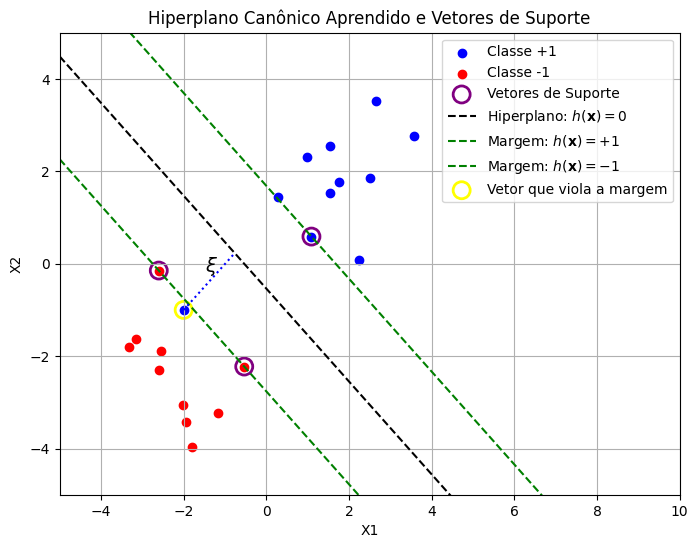

In [6]:
# Vetor que viola a margem
x_viola = np.array([-2,-1])

# Adicionar ponto de viola√ß√£o:
X = np.vstack((X,x_viola))
y = np.hstack((y,1))

# Obter os coeficientes do hiperplano
w = np.array([0.45182465, 0.4494984 ])
b = 0.24209387304919786

# Identificar vetores de suporte
support_vectors = np.array([[-0.53435123, -2.2257763 ],
                          [-2.60170661, -0.14772182],
                          [ 1.09197592,  0.5876963 ]])

# Visualiza√ß√£o
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Classe +1')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Classe -1')

# Destacar vetores de suporte
plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
            s=150, facecolors='none', edgecolors='purple', linewidths=2, label='Vetores de Suporte')

# Gerar pontos para o gr√°fico do hiperplano e margens
x_vals = np.linspace(-5, 10, 200)
y_vals = -(w[0] * x_vals + b) / w[1]
y_margin_plus = -(w[0] * x_vals + b - 1) / w[1]
y_margin_minus = -(w[0] * x_vals + b + 1) / w[1]

# Plotar hiperplano e margens can√¥nicas
plt.plot(x_vals, y_vals, 'k--', label='Hiperplano: $h(\\mathbf{x})=0$')
plt.plot(x_vals, y_margin_plus, 'g--', label='Margem: $h(\\mathbf{x})=+1$')
plt.plot(x_vals, y_margin_minus, 'g--', label='Margem: $h(\\mathbf{x})=-1$')


# Destacar vetor que viola a margem
plt.scatter(x_viola[0], x_viola[1],
            s=150, facecolors='none', edgecolors='yellow', linewidths=2, label='Vetor que viola a margem')

def projetar_no_hiperplano(x, w, b):
    return x - ((np.dot(w, x) + b) / np.dot(w, w)) * w

x_proj = projetar_no_hiperplano(x_viola, w, b)
plt.plot([x_viola[0], x_proj[0]], [x_viola[1], x_proj[1]], 'b:')

# Adicionar anota√ß√£o da letra xi
plt.annotate(r'$\xi$', xy=((x_viola[0]-0.2 + x_proj[0]) / 2, (x_viola[1] - 0.2 + x_proj[1]) / 2 + 0.3),
             fontsize=14)

plt.title("Hiperplano Can√¥nico Aprendido e Vetores de Suporte")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.xlim(-5, 10)
plt.ylim(-5, 5)
plt.show()


Vamos resolver esse problema analiticamente e visualizar a solu√ß√£o.

In [7]:
import numpy as np
import cvxpy as cp

# Dados de entrada (X: n x d, y: n)
# Suponha que voc√™ j√° tem X e y definidos
n, d = X.shape
C = 1.0  # par√¢metro de regulariza√ß√£o

# Vari√°veis de otimiza√ß√£o
w = cp.Variable(d)
b = cp.Variable()
xi = cp.Variable(n)

# Fun√ß√£o objetivo
objective = cp.Minimize(0.5 * cp.sum_squares(w) + C * cp.sum(xi))

# Restri√ß√µes
constraints = [y[i] * (X[i] @ w + b) >= 1 - xi[i] for i in range(n)]
constraints += [xi >= 0]

# Resolver o problema
problem = cp.Problem(objective, constraints)
problem.solve()

# Resultados
print("w:", w.value)
print("b:", b.value)
print("Margem:", 2 / np.linalg.norm(w.value))


w: [0.4519453  0.44961841]
b: 0.24224753310917854
Margem: 3.137235513919606


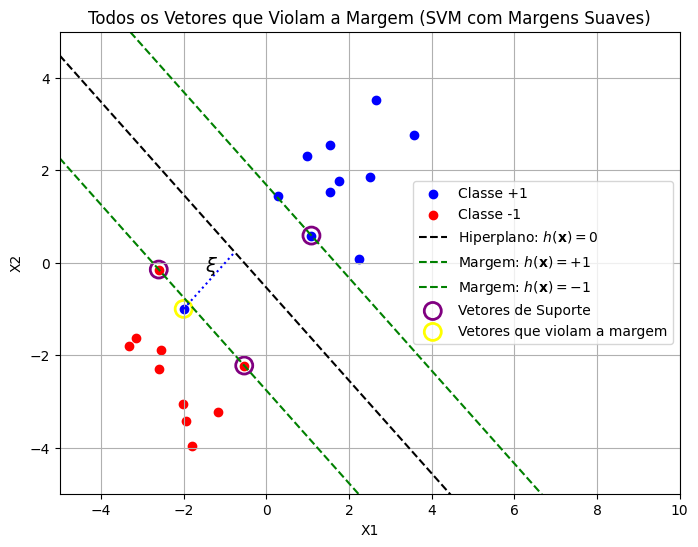

In [8]:
w = w.value
b = b.value

# Calcular h(x) = w^T x + b para todos os pontos
h_vals = X @ w + b

# Calcular margem y_i * h(x_i)
margins = y * h_vals

# Identificar todos os vetores que violam a margem (margem < 1)
violating_indices = np.where(margins < 1)[0]
violating_points = X[violating_indices]

# Replotar gr√°fico com todos os violadores destacados
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Classe +1')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Classe -1')

# Hiperplanos
x_vals = np.linspace(-5, 10, 200)
y_vals = -(w[0] * x_vals + b) / w[1]
y_margin_plus = -(w[0] * x_vals + b - 1) / w[1]
y_margin_minus = -(w[0] * x_vals + b + 1) / w[1]
plt.plot(x_vals, y_vals, 'k--', label='Hiperplano: $h(\\mathbf{x})=0$')
plt.plot(x_vals, y_margin_plus, 'g--', label='Margem: $h(\\mathbf{x})=+1$')
plt.plot(x_vals, y_margin_minus, 'g--', label='Margem: $h(\\mathbf{x})=-1$')


# Destacar vetores de suporte
support_indices = np.where((margins > 0) & (margins <= 1 + 1e-5))[0]
support_vectors = X[support_indices]

plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
            s=150, facecolors='none', edgecolors='purple', linewidths=2, label='Vetores de Suporte')


# Destacar todos os vetores que violam a margem
plt.scatter(violating_points[:, 0], violating_points[:, 1],
            s=150, facecolors='none', edgecolors='yellow', linewidths=2, label='Vetores que violam a margem')

def projetar_no_hiperplano(x, w, b):
    return x - ((np.dot(w, x) + b) / np.dot(w, w)) * w

for i in range(violating_points.shape[0]):
  x_proj = projetar_no_hiperplano([violating_points[i,0],violating_points[i,1]], w, b)
  plt.plot([violating_points[i,0], x_proj[0]], [violating_points[i,1], x_proj[1]], 'b:')

  # Adicionar anota√ß√£o da letra xi
  plt.annotate(r'$\xi$', xy=((violating_points[i,0]-0.2 + x_proj[0]) / 2, (violating_points[i,1] - 0.2 + x_proj[1]) / 2 + 0.3),
              fontsize=14)


plt.title("Todos os Vetores que Violam a Margem (SVM com Margens Suaves)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.xlim(-5, 10)
plt.ylim(-5, 5)
plt.show()


# SVMs com Kernels: Lidando com Fronteiras N√£o Lineares

At√© agora, trabalhamos com **SVMs lineares**, que buscam um **hiperplano linear** capaz de separar as classes no espa√ßo original dos dados. No entanto, em muitos problemas reais, os dados **n√£o s√£o linearmente separ√°veis** ‚Äî ou seja, **n√£o existe uma linha (ou plano) que separe perfeitamente as classes** no espa√ßo original.

Para lidar com esses casos, introduzimos o conceito de **SVM com Kernels**.


A ideia √© **projetar os dados para um espa√ßo de maior dimens√£o**, chamado de **espa√ßo de caracter√≠sticas**, onde a separa√ß√£o **se torne linear**. Esse mapeamento √© feito por uma fun√ß√£o $\phi(\mathbf{x})$:

$$
\phi: \mathbb{R}^n \rightarrow \mathbb{R}^m \quad (m > n)
$$




## Exemplo de Dados N√£o Linearmente Separ√°veis em $\mathbb{R}^2$

Neste exemplo, geramos dois conjuntos de pontos que representam duas classes:

- A **classe -1** est√° distribu√≠da em um **c√≠rculo interno** (menor raio);
- A **classe +1** est√° distribu√≠da em um **c√≠rculo externo** (maior raio).

Esses dados s√£o **claramente n√£o separ√°veis por uma reta** em $\mathbb{R}^2$. Qualquer tentativa de tra√ßar uma linha de separa√ß√£o falharia, pois os dados das duas classes se sobrep√µem de forma conc√™ntrica.

Esse tipo de distribui√ß√£o motiva o uso de **m√©todos de transforma√ß√£o do espa√ßo**, como o **uso de kernels em SVMs**.



In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------
# Gerar dados de duas classes circulares
# --------------------------
np.random.seed(42)
n_points = 100

# Classe -1 (c√≠rculo interno)
theta_inner = 2 * np.pi * np.random.rand(n_points)
r_inner = 0.5 + 0.02 * np.random.randn(n_points)
x1_inner = r_inner * np.cos(theta_inner)
x2_inner = r_inner * np.sin(theta_inner)

# Classe +1 (c√≠rculo externo)
theta_outer = 2 * np.pi * np.random.rand(n_points)
r_outer = 1.0 + 0.02 * np.random.randn(n_points)
x1_outer = r_outer * np.cos(theta_outer)
x2_outer = r_outer * np.sin(theta_outer)

# --------------------------
# Parte 1: plotar em R¬≤
# --------------------------
plt.figure(figsize=(6, 6))
plt.scatter(x1_inner, x2_inner, color='red', label='Classe -1', alpha=0.7)
plt.scatter(x1_outer, x2_outer, color='blue', label='Classe +1', alpha=0.7)

plt.title("Classes em $\\mathbb{R}^2$: Distribui√ß√£o Circular N√£o Linearmente Separ√°vel")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

## Transforma√ß√£o para $\mathbb{R}^3$ com $\phi(x_1, x_2)$

Aplicamos a seguinte transforma√ß√£o n√£o linear aos dados:

$$
\phi(x_1, x_2) = \left(x_1^2,\ \sqrt{2}x_1x_2,\ x_2^2\right)
$$

Essa transforma√ß√£o leva os dados de $\mathbb{R}^2$ para $\mathbb{R}^3$, de forma que:

- Pontos da **classe -1** (c√≠rculo interno) permanecem agrupados pr√≥ximos de uma regi√£o inferior do espa√ßo;
- Pontos da **classe +1** (c√≠rculo externo) s√£o projetados em uma regi√£o superior do espa√ßo;
- As duas classes tornam-se **linearmente separ√°veis por um plano** nesse novo espa√ßo tridimensional.

Este exemplo ilustra o poder do **"truque do kernel"**: ao inv√©s de calcular $\phi$ explicitamente, usamos uma fun√ß√£o de kernel que calcula o **produto escalar no espa√ßo transformado**, possibilitando **SVMs n√£o lineares** sem sair do espa√ßo original de entrada.


In [10]:
import plotly.graph_objects as go

# Transforma√ß√£o phi
def phi(x1, x2):
    return x1**2, np.sqrt(2)*x1*x2, x2**2

phi_inner = phi(x1_inner, x2_inner)
phi_outer = phi(x1_outer, x2_outer)

# Criar figura interativa com Plotly
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=phi_inner[0], y=phi_inner[1], z=phi_inner[2],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.7),
    name='Classe -1'
))

fig.add_trace(go.Scatter3d(
    x=phi_outer[0], y=phi_outer[1], z=phi_outer[2],
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.7),
    name='Classe +1'
))

fig.update_layout(
    title='Transforma√ß√£o œÜ(x‚ÇÅ, x‚ÇÇ) = (x‚ÇÅ¬≤, ‚àö2¬∑x‚ÇÅ¬∑x‚ÇÇ, x‚ÇÇ¬≤)',
    scene=dict(
        xaxis_title='œÜ‚ÇÅ = x‚ÇÅ¬≤',
        yaxis_title='œÜ‚ÇÇ = ‚àö2¬∑x‚ÇÅ¬∑x‚ÇÇ',
        zaxis_title='œÜ‚ÇÉ = x‚ÇÇ¬≤',
    ),
    legend=dict(x=0.02, y=0.98),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


## Do Primal ao Dual: SVMs N√£o Lineares com Kernel

A ideia central das SVMs com kernel √© **transformar o espa√ßo original dos dados** com uma fun√ß√£o n√£o linear $\phi(\mathbf{x})$, de modo que os dados se tornem **linearmente separ√°veis em um novo espa√ßo de caracter√≠sticas**.

### Problema Primal com Transforma√ß√£o Impl√≠cita

O problema de otimiza√ß√£o primal para SVMs com margens suaves, considerando uma transforma√ß√£o n√£o linear $\phi: \mathbb{R}^n \rightarrow \mathbb{R}^m$, √© dado por:

$$
\begin{aligned}
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \quad & \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \xi_i \\
\text{sujeito a} \quad & y_i \left(\mathbf{w}^\top \phi(\mathbf{x}_i) + b\right) \geq 1 - \xi_i \\
& \xi_i \geq 0, \quad \forall i
\end{aligned}
$$

O problema aqui √© que, **em geral, n√£o conhecemos explicitamente a transforma√ß√£o $\phi$**. Em muitos casos, $\phi(\mathbf{x})$ pode mapear para um espa√ßo de **dimens√£o muito alta ou at√© infinita**, como acontece com o kernel RBF.

---

### O Truque do Kernel

A observa√ß√£o fundamental √© que a transforma√ß√£o $\phi$ aparece **apenas em produtos escalares** do tipo $\phi(\mathbf{x}_i)^\top \phi(\mathbf{x}_j)$. Assim, ao inv√©s de trabalhar com $\phi$ diretamente, definimos uma **fun√ß√£o de kernel** $K$ que calcula esse produto de forma eficiente:

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)^\top \phi(\mathbf{x}_j)
$$

---

### Formula√ß√£o Dual: O Caminho Vi√°vel

Com isso, reescrevemos o problema como uma **otimiza√ß√£o dual** em termos das vari√°veis $\alpha_i$:

$$
\begin{aligned}
\max_{\boldsymbol{\alpha}} \quad & \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n \alpha_i \alpha_j y_i y_j K(\mathbf{x}_i, \mathbf{x}_j) \\
\text{sujeito a} \quad & 0 \leq \alpha_i \leq C \\
& \sum_{i=1}^n \alpha_i y_i = 0
\end{aligned}
$$

Este problema dual pode ser resolvido de forma eficiente, e evita a necessidade de conhecer ou computar $\phi$ explicitamente.

---

## O Classificador no Espa√ßo Dual: Fun√ß√£o $g(\mathbf{x})$

Ao resolvermos a SVM via sua **formula√ß√£o dual**, o vetor de pesos $\mathbf{w}$ **n√£o √© explicitamente calculado**. Em vez disso, obtemos os **multiplicadores de Lagrange** $\alpha_i$, que indicam a influ√™ncia de cada exemplo de treinamento na constru√ß√£o da fronteira de decis√£o.

O classificador aprendido assume agora a forma de uma **fun√ß√£o de decis√£o baseada em kernel**, definida como:

$$
g(\mathbf{x}) = \sum_{i \in \mathcal{S}} \alpha_i y_i K(\mathbf{x}_i, \mathbf{x}) + b
$$

onde:
- $\mathcal{S}$ √© o conjunto de **vetores de suporte** ($\alpha_i > 0$),
- $K(\cdot, \cdot)$ √© a **fun√ß√£o de kernel** escolhida (por exemplo, RBF),
- $b$ √© o **vi√©s (bias)** calculado a partir dos vetores de suporte.

A decis√£o final √© dada por:

$$
\hat{y} = \text{sinal}(g(\mathbf{x}))
$$

---


### Conclus√£o

Ao passar para o dual, conseguimos treinar SVMs **n√£o lineares** com **grande efici√™ncia computacional**, utilizando apenas fun√ß√µes de kernel. Essa abordagem permite construir **fronteiras de decis√£o complexas** sem sair do espa√ßo original ‚Äî a m√°gica do **kernel trick**.


> üìå **Observa√ß√£o: Problemas Primal e Dual na Otimiza√ß√£o Convexa**
>
> Em problemas de otimiza√ß√£o convexa, como nas SVMs, √© comum existirem duas formula√ß√µes matematicamente equivalentes:
>
> - O **problema primal**, que expressa diretamente o objetivo original (por exemplo, minimizar $\|\mathbf{w}\|^2$);
> - O **problema dual**, que √© derivado do primal usando **multiplicadores de Lagrange** e o **teorema da dualidade**.
>
> Ao construir a **fun√ß√£o Lagrangiana** e aplicar condi√ß√µes de otimalidade (KKT), obtemos a vers√£o dual. Em muitos casos, como nas SVMs com kernel, **resolver o dual √© mais vantajoso**, porque ele depende apenas de **produtos escalares** e permite usar o **truque do kernel**.
>
> Ambos os problemas possuem a **mesma solu√ß√£o √≥tima para o valor da fun√ß√£o objetivo** sob condi√ß√µes de regularidade (forte dualidade).
>
> üìö Refer√™ncia cl√°ssica:  
> **Boyd & Vandenberghe (2004). Convex Optimization.**  
> Cap√≠tulo 5 ‚Äì Duality.

Conte√∫do UFSCar (Pedro Munari): https://www.youtube.com/watch?v=u_vNrV14RXM&list=PLjK8TkmwOe0p8Iv4qfaGniaDRKRkgro_Q



### Exemplos de Kernels Comuns:

- **Linear**: $ K(\mathbf{x}, \mathbf{z}) = \mathbf{x}^\top \mathbf{z} $
- **Polinomial**: $ K(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^\top \mathbf{z} + c)^d $
- **RBF (gaussiano)**: $ K(\mathbf{x}, \mathbf{z}) = \exp\left(-\gamma \|\mathbf{x} - \mathbf{z}\|^2\right) $
- **Sigmoide**: $ K(\mathbf{x}, \mathbf{z}) = \tanh(\alpha \mathbf{x}^\top \mathbf{z} + c) $

---

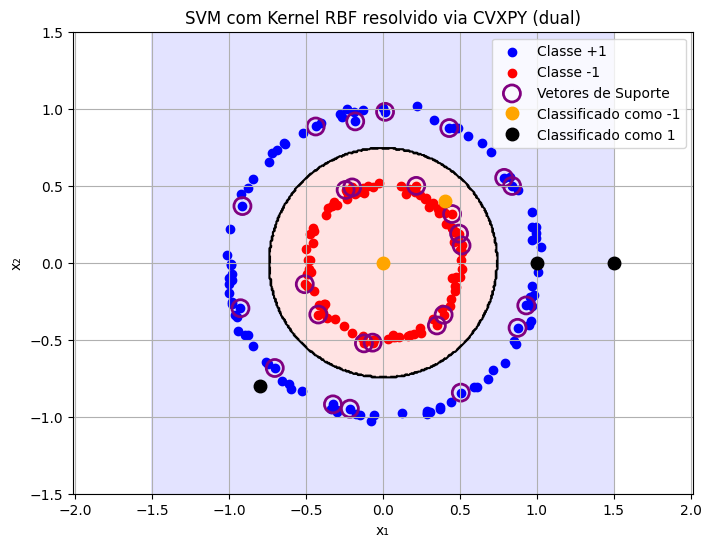

In [11]:
# Reexecutar o c√≥digo completo agora incluindo todas as vari√°veis necess√°rias

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import cvxpy as cp

# Gerar dados
np.random.seed(42)
n_points = 100

# Classe -1 (c√≠rculo interno)
theta_inner = 2 * np.pi * np.random.rand(n_points)
r_inner = 0.5 + 0.02 * np.random.randn(n_points)
x1_inner = r_inner * np.cos(theta_inner)
x2_inner = r_inner * np.sin(theta_inner)

# Classe +1 (c√≠rculo externo)
theta_outer = 2 * np.pi * np.random.rand(n_points)
r_outer = 1.0 + 0.02 * np.random.randn(n_points)
x1_outer = r_outer * np.cos(theta_outer)
x2_outer = r_outer * np.sin(theta_outer)

# Dataset
X_rbf = np.vstack([
    np.column_stack((x1_inner, x2_inner)),
    np.column_stack((x1_outer, x2_outer))
])
y_rbf = np.array([-1]*n_points + [1]*n_points)

# Kernel RBF
def rbf_kernel(x, y, gamma=1.0):
    sq_dists = np.sum(x**2, axis=1).reshape(-1, 1) + np.sum(y**2, axis=1) - 2 * np.dot(x, y.T)
    return np.exp(-gamma * sq_dists)

# Par√¢metro gamma
gamma = 1.0
K_rbf = rbf_kernel(X_rbf, X_rbf, gamma)

# Problema dual com cvxpy
n = X_rbf.shape[0]
Q = np.outer(y_rbf, y_rbf) * K_rbf
alpha = cp.Variable(n)
C = 1.0

objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, cp.psd_wrap(Q)))
constraints = [
    alpha >= 0,
    alpha <= C,
    cp.sum(cp.multiply(alpha, y_rbf)) == 0
]

problem = cp.Problem(objective, constraints)
problem.solve()

# Recuperar alphas e vetores de suporte
alpha_val = alpha.value
support_indices = np.where(alpha_val > 1e-5)[0]
support_vectors = X_rbf[support_indices]
support_labels = y_rbf[support_indices]
support_alphas = alpha_val[support_indices]

# Calcular bias
def rbf_kernel_vector(x, Y, gamma):
    return np.exp(-gamma * np.sum((Y - x)**2, axis=1))

b_vals = support_labels - np.sum((support_alphas * support_labels)[:, None] * rbf_kernel(support_vectors, support_vectors, gamma), axis=0)
b_rbf = np.mean(b_vals)

# Classificador sinal
def classificador_rbf_manual(x):
    k_vals = rbf_kernel_vector(np.array(x), support_vectors, gamma)
    return np.sign(np.sum(support_alphas * support_labels * k_vals) + b_rbf)

# Pontos de teste
pontos_teste = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.5, 0.0],
    [-0.8, -0.8],
    [0.4, 0.4]
])
resultados_cvx = [classificador_rbf_manual(p) for p in pontos_teste]

# Gerar grade para visualiza√ß√£o
x_vals = np.linspace(-1.5, 1.5, 400)
y_vals = np.linspace(-1.5, 1.5, 400)
xx, yy = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(xx)

for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        Z[i, j] = classificador_rbf_manual([xx[i, j], yy[i, j]])


# Plotar resultado
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], colors=['#FFBBBB', '#BBBBFF'], alpha=0.4)
plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors='k', linestyles=['--', '-', '--'])

plt.scatter(X_rbf[y_rbf == 1][:, 0], X_rbf[y_rbf == 1][:, 1], color='blue', label='Classe +1')
plt.scatter(X_rbf[y_rbf == -1][:, 0], X_rbf[y_rbf == -1][:, 1], color='red', label='Classe -1')



plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
            s=150, facecolors='none', edgecolors='purple', linewidths=2, label='Vetores de Suporte')


for i, p in enumerate(pontos_teste):
    cor = 'k' if resultados_cvx[i] == 1 else 'orange'
    plt.plot(p[0], p[1], 'o', color=cor, markersize=9, label=f'Classificado como {int(resultados_cvx[i])}' if i in [0,1] else "")

plt.title("SVM com Kernel RBF resolvido via CVXPY (dual)")
plt.xlabel("x‚ÇÅ")
plt.ylabel("x‚ÇÇ")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()




# SVM para Regress√£o: Caso com Margem R√≠gida

Assim como a SVM de classifica√ß√£o busca um hiperplano que separa classes com m√°xima margem, a **SVM de regress√£o** (tamb√©m conhecida como **SVR ‚Äî Support Vector Regression**) busca uma **fun√ß√£o preditiva linear** que se mantenha **dentro de uma faixa de toler√¢ncia $\epsilon$ em torno dos valores reais** da vari√°vel de sa√≠da.

---

###  Objetivo

Queremos encontrar uma fun√ß√£o:

$$
f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b
$$

que aproxime os pares de treinamento $(\mathbf{x}_i, y_i)$ de forma que os **erros absolutos** fiquem **dentro de uma margem fixa $\epsilon$**, ou seja:

$$
|y_i - f(\mathbf{x}_i)| \leq \epsilon
$$

---

### Restri√ß√µes no Caso de Margem R√≠gida

Essa condi√ß√£o de toler√¢ncia pode ser expressa como duas **restri√ß√µes lineares** para cada ponto:

$$
\begin{cases}
y_i - (\mathbf{w}^\top \mathbf{x}_i + b) \leq \epsilon \\
(\mathbf{w}^\top \mathbf{x}_i + b) - y_i \leq \epsilon
\end{cases}
\quad \text{ou, de forma compacta:} \quad
|y_i - f(\mathbf{x}_i)| \leq \epsilon
$$

Isso define uma **faixa (tubo $\epsilon$)** dentro da qual o modelo n√£o ser√° penalizado ‚Äî essa √© a **zona de toler√¢ncia**.

---

### O que n√£o muda:

- A fun√ß√£o objetivo continua sendo a **minimiza√ß√£o da norma do vetor de pesos** $\frac{1}{2}\|\mathbf{w}\|^2$, ou seja, buscamos uma solu√ß√£o **simples** e com boa **capacidade de generaliza√ß√£o**.
- Ainda se trata de um **problema de otimiza√ß√£o convexa** com restri√ß√µes lineares.

Matematicamente,

$$
\begin{aligned}
\min_{\mathbf{w},b} \quad & \frac{1}{2} \|\mathbf{w}\|^2 \\
\text{sujeito a} \quad &|y_i - f(\mathbf{x}_i)| \leq \epsilon, \quad \forall i = 1,2,..,n.
\end{aligned}
$$


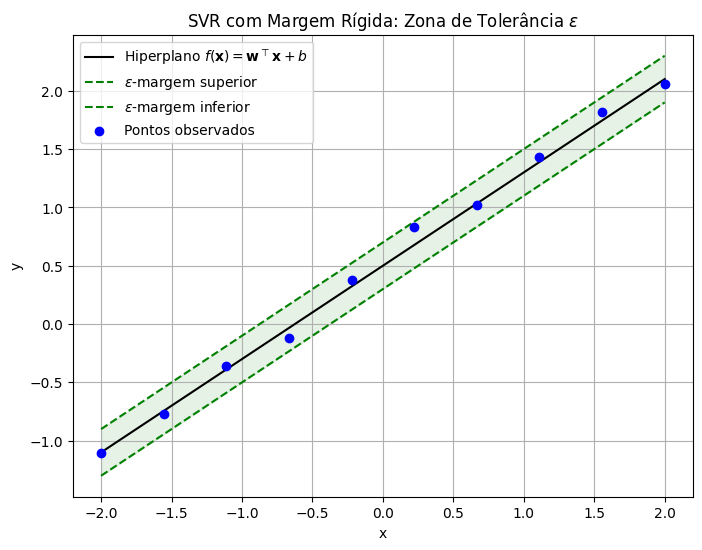

In [12]:
# Pontos de exemplo (x, y)
x_vals = np.linspace(-2, 2, 10)
y_true = 0.8 * x_vals + 0.5
y_obs = y_true + np.random.normal(0, 0.1, size=x_vals.shape)

# Hiperplano aprendido (reta de regress√£o)
def f(x):
    return 0.8 * x + 0.5

# Margem epsilon
epsilon = 0.2
upper_margin = f(x_vals) + epsilon
lower_margin = f(x_vals) - epsilon

# Plotar
plt.figure(figsize=(8, 6))
plt.plot(x_vals, f(x_vals), 'k-', label=r'Hiperplano $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b$')
plt.plot(x_vals, upper_margin, 'g--', label=r'$\epsilon$-margem superior')
plt.plot(x_vals, lower_margin, 'g--', label=r'$\epsilon$-margem inferior')
plt.fill_between(x_vals, lower_margin, upper_margin, color='green', alpha=0.1)

plt.scatter(x_vals, y_obs, color='blue', label='Pontos observados', zorder=5)

plt.title("SVR com Margem R√≠gida: Zona de Toler√¢ncia $\epsilon$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


## SVR com Margens Suaves: Violando a Toler√¢ncia de $\epsilon$

Na pr√°tica, nem todos os pontos do conjunto de dados estar√£o perfeitamente dentro da faixa de toler√¢ncia $\epsilon$. Para lidar com isso, generalizamos a SVR para permitir **viola√ß√µes da margem**, introduzindo as chamadas **vari√°veis de folga** $\xi_i$ e $\xi_i^-$:

- $\xi_i$: quanto o valor real $y_i$ ultrapassa a **margem superior**.
- $\xi_i^-$: quanto o valor real $y_i$ ultrapassa a **margem inferior**.

Essas vari√°veis s√£o **n√£o negativas** e indicam o **quanto o modelo erra al√©m da toler√¢ncia permitida**.

---

### Problema de Otimiza√ß√£o com Margens Suaves

O problema de SVR com margens suaves √©:

$$
\begin{aligned}
\min_{\mathbf{w}, b, \boldsymbol{\xi}, \boldsymbol{\xi}^-} \quad & \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n (\xi_i + \xi_i^*) \\
\text{sujeito a} \quad &
\begin{cases}
y_i - (\mathbf{w}^\top \mathbf{x}_i + b) \leq \epsilon + \xi_i \\
(\mathbf{w}^\top \mathbf{x}_i + b) - y_i \leq \epsilon + \xi_i^- \\
\xi_i, \xi_i^* \geq 0
\end{cases}
\quad \forall i
\end{aligned}
$$

---

### Interpreta√ß√£o

- O primeiro termo da fun√ß√£o objetivo, $\frac{1}{2}\|\mathbf{w}\|^2$, continua promovendo **simplicidade do modelo**.
- O segundo termo penaliza os **exemplos que est√£o fora da faixa $\epsilon$**, controlado pelo par√¢metro $C$:
  - **$C$ grande**: penaliza fortemente os erros ‚Üí modelo mais fiel ao treino;
  - **$C$ pequeno**: permite mais erros ‚Üí modelo mais suave e tolerante a ru√≠do.

---

### Vantagem da SVR

Esse modelo permite que a SVM de regress√£o:
- Mantenha uma faixa de erro ‚Äúaceit√°vel‚Äù sem penaliza√ß√£o;
- Controle de forma elegante o **trade-off entre erro e complexidade**;
- Utilize os princ√≠pios da **margem m√°xima**, mesmo em tarefas de predi√ß√£o cont√≠nua.

Na pr√≥xima etapa, vamos visualizar graficamente como essa viola√ß√£o da margem √© interpretada e incluir o papel das vari√°veis $\xi$ e $\xi^-$.


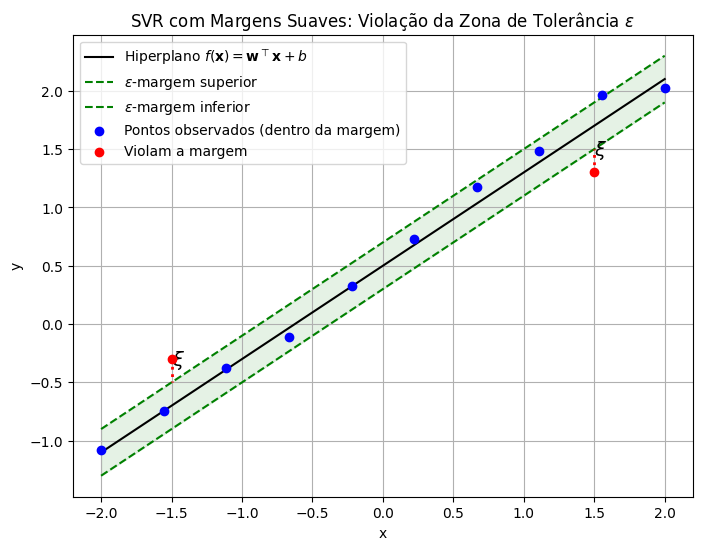

In [13]:
# Reutilizar os pontos anteriores e adicionar dois que violam a margem

# Dados de exemplo
x_vals = np.linspace(-2, 2, 10)
y_true = 0.8 * x_vals + 0.5
y_obs = y_true + np.random.normal(0, 0.1, size=x_vals.shape)

# Adicionar pontos que violam a margem
x_violadores = np.array([-1.5, 1.5])
y_violadores = np.array([f(-1.5) + 0.4, f(1.5) - 0.4])  # um acima, um abaixo da margem

# Margens
epsilon = 0.2
upper_margin = f(x_vals) + epsilon
lower_margin = f(x_vals) - epsilon

# Plotar
plt.figure(figsize=(8, 6))
plt.plot(x_vals, f(x_vals), 'k-', label=r'Hiperplano $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b$')
plt.plot(x_vals, upper_margin, 'g--', label=r'$\epsilon$-margem superior')
plt.plot(x_vals, lower_margin, 'g--', label=r'$\epsilon$-margem inferior')
plt.fill_between(x_vals, lower_margin, upper_margin, color='green', alpha=0.1)

# Pontos dentro da margem
plt.scatter(x_vals, y_obs, color='blue', label='Pontos observados (dentro da margem)', zorder=5)

# Pontos que violam a margem
plt.scatter(x_violadores, y_violadores, color='red', label='Violam a margem', zorder=5)

# Desenhar as setas para representar Œæ e Œæ*
for i in range(len(x_violadores)):
    x_v = x_violadores[i]
    y_v = y_violadores[i]
    y_proj = f(x_v) + epsilon if y_v > f(x_v) + epsilon else f(x_v) - epsilon
    plt.annotate(r'$\xi$', xy=((x_v + x_v)/2, (y_v + y_proj)/2 + 0.05), fontsize=14)
    plt.plot([x_v, x_v], [y_v, y_proj], 'r:', linewidth=2)

plt.title("SVR com Margens Suaves: Viola√ß√£o da Zona de Toler√¢ncia $\epsilon$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


## SVR com Kernels: Generalizando para Rela√ß√µes N√£o Lineares

Assim como na classifica√ß√£o, a regress√£o com SVM tamb√©m pode ser generalizada para **modelar rela√ß√µes n√£o lineares** entre as vari√°veis. Para isso, utilizamos o mesmo princ√≠pio: aplicamos uma **transforma√ß√£o n√£o linear $\phi(\mathbf{x})$** que leva os dados a um novo espa√ßo onde a regress√£o se torne **linear**.

No entanto, em vez de calcular explicitamente $\phi(\mathbf{x})$, usamos uma **fun√ß√£o de kernel** $K(\mathbf{x}_i, \mathbf{x}_j)$ que computa diretamente os produtos escalares no espa√ßo transformado:

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)^\top \phi(\mathbf{x}_j)
$$

---

###  Problema Dual da SVR com Kernel

Ao resolver o problema de SVR com margens suaves via **formula√ß√£o dual**, obtemos um par de vari√°veis $\alpha_i$ e $\alpha_i^-$ para cada ponto de treinamento. A forma dual √©:

$$
\begin{aligned}
\max_{\boldsymbol{\alpha}, \boldsymbol{\alpha}^-} \quad & -\frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n (\alpha_i - \alpha_i^-)(\alpha_j - \alpha_j^-) K(\mathbf{x}_i, \mathbf{x}_j) \\
& + \epsilon \sum_{i=1}^n (\alpha_i + \alpha_i^-) - \sum_{i=1}^n y_i (\alpha_i - \alpha_i^-) \\
\text{sujeito a} \quad & 0 \leq \alpha_i, \alpha_i^- \leq C, \quad \sum_{i=1}^n (\alpha_i - \alpha_i^-) = 0
\end{aligned}
$$

---

###  O Classificador Final

Ap√≥s resolver o problema dual, a fun√ß√£o de predi√ß√£o √© dada por:

$$
f(\mathbf{x}) = \sum_{i=1}^n (\alpha_i - \alpha_i^-) K(\mathbf{x}_i, \mathbf{x}) + b
$$

Note que:
- Apenas os **pontos com $\alpha_i > 0$ ou $\alpha_i^- > 0$** (os vetores de suporte) contribuem para a predi√ß√£o;
- O modelo pode construir **fun√ß√µes n√£o lineares de regress√£o** sem nunca precisar representar explicitamente o espa√ßo de alta dimens√£o $\phi(\mathbf{x})$;
- O vi√©s $b$ √© estimado a partir dos vetores de suporte localizados **dentro da margem** ($0 < \alpha_i < C$).

---

### Benef√≠cios

- O uso de **kernels** permite adaptar o modelo a padr√µes complexos nos dados;
- A regress√£o √© **controlada por margens e penaliza√ß√µes**, o que proporciona boa **capacidade de generaliza√ß√£o**;
- A abordagem mant√©m o rigor geom√©trico da SVM, agora aplicado √† predi√ß√£o de vari√°veis cont√≠nuas.


Correla√ß√£o com os dados reais: 0.9814
MSE: 0.00647
RMSE: 0.08046
MAE: 0.06914


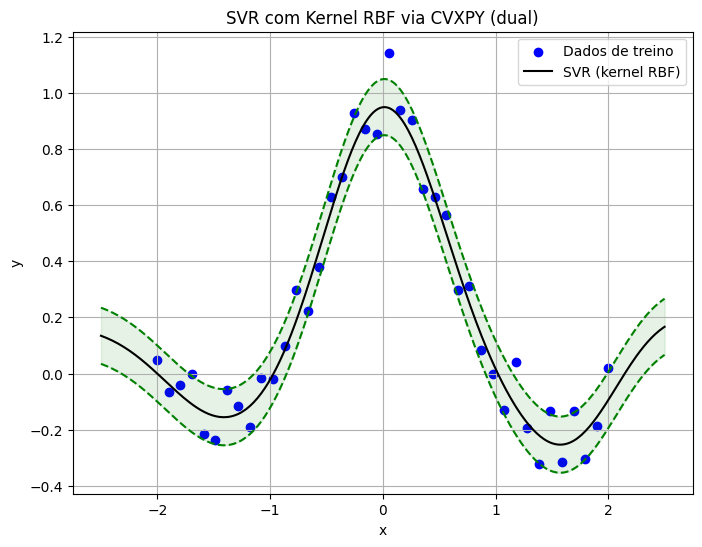

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Dados de regress√£o
np.random.seed(42)
x_reg = np.linspace(-2, 2, 40).reshape(-1, 1)
y_reg = np.sinc(x_reg).ravel() + 0.1 * np.random.randn(*x_reg.shape).ravel()

# Kernel RBF
def rbf_kernel(X1, X2, gamma):
    sq_dists = np.sum(X1**2, axis=1).reshape(-1,1) + np.sum(X2**2, axis=1) - 2 * X1 @ X2.T
    return np.exp(-gamma * sq_dists)

# Par√¢metros
n = x_reg.shape[0]
C = 1.0
epsilon = 0.1
gamma = 2.0
K = rbf_kernel(x_reg, x_reg, gamma)

# Problema dual
alpha = cp.Variable(n)
alpha_star = cp.Variable(n)
alpha_diff = alpha - alpha_star

objective = cp.Maximize(
    -0.5 * cp.quad_form(alpha_diff, cp.psd_wrap(K)) -
    epsilon * cp.sum(alpha + alpha_star) +
    cp.sum(cp.multiply(y_reg, alpha_diff))
)

constraints = [
    alpha >= 0,
    alpha <= C,
    alpha_star >= 0,
    alpha_star <= C,
    cp.sum(alpha_diff) == 0
]

problem = cp.Problem(objective, constraints)
problem.solve()

# Obter solu√ß√£o
alpha_val = alpha.value
alpha_star_val = alpha_star.value
alpha_diff_val = alpha_val - alpha_star_val

# Calcular b corretamente
inside_margin = (alpha_val > 1e-5) & (alpha_val < C - 1e-5)
inside_margin |= (alpha_star_val > 1e-5) & (alpha_star_val < C - 1e-5)
b_vals = []
for i in np.where(inside_margin)[0]:
    b_i = y_reg[i] - np.sum(alpha_diff_val * K[i, :])
    b_vals.append(b_i)
b_rbf = np.mean(b_vals)

# Preditor
def svr_predict(x):
    k = rbf_kernel(x_reg, x.reshape(1, -1), gamma).ravel()
    return np.sum(alpha_diff_val * k) + b_rbf

# Predi√ß√£o
x_test = np.linspace(-2.5, 2.5, 300).reshape(-1, 1)
y_pred = np.array([svr_predict(xi) for xi in x_test])

# Correla√ß√£o com os dados de treino
y_train_pred = np.array([svr_predict(xi) for xi in x_reg])
correlacao, _ = pearsonr(y_train_pred, y_reg)
print(f"Correla√ß√£o com os dados reais: {correlacao:.4f}")


# Calcular m√©tricas
mse = mean_squared_error(y_reg, y_train_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_reg, y_train_pred)

print(f"MSE: {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")

# Visualiza√ß√£o
plt.figure(figsize=(8, 6))
plt.scatter(x_reg, y_reg, color='blue', label='Dados de treino')
plt.plot(x_test, y_pred, 'k-', label='SVR (kernel RBF)')
plt.plot(x_test, y_pred + epsilon, 'g--')
plt.plot(x_test, y_pred - epsilon, 'g--')
plt.fill_between(x_test.ravel(), y_pred - epsilon, y_pred + epsilon, color='green', alpha=0.1)
plt.title("SVR com Kernel RBF via CVXPY (dual)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


---

# Exerc√≠cios Resolvidos

### Exerc√≠cio 1: Sobreviventes do Titanic com SVM

Neste exerc√≠cio, voc√™ ir√° utilizar a base de dados do Titanic para treinar e testar um classificador baseado em **M√°quinas de Vetores de Suporte (SVM)**.

#### Etapas:

1. **Carregue os dados** da competi√ß√£o do Titanic (dispon√≠vel em: https://www.kaggle.com/c/titanic/data).
   - Utilize apenas o arquivo `train.csv`.

2. **Reparta o dataset manualmente**:
   - Use as **primeiras 75% das linhas** como conjunto de **treinamento**;
   - Use as **√∫ltimas 25% das linhas** como conjunto de **teste**.

3. **Pr√©-processamento dos dados**:
   - Remova colunas n√£o informativas (`PassengerId`, `Name`, `Ticket`, `Cabin`);
   - Converta vari√°veis categ√≥ricas em num√©ricas (ex: `Sex`, `Embarked`);
   - Preencha valores ausentes (`Age`, `Embarked`, etc.).

4. **Treine uma SVM**:
   - Use as fun√ß√µes discutidas em sala de aula;
   - Escolha um kernel (ex: `'linear'` ou `'rbf'`);
   - Treine o modelo sobre os dados de treino.

5. **Avalie o modelo**:
   - Aplique seu modelo ao conjunto de teste para estimar se um passageiro sobreviveu ou n√£o;
   - Qual a porcentagem de acertos de seu modelo?

6. **Interpreta√ß√£o e Discuss√£o**:
   - O desempenho foi satisfat√≥rio?
   - Qual kernel parece funcionar melhor?


In [16]:
# Upload do arquivo `train.csv` ser√° necess√°rio para resolver o exerc√≠cio conforme solicitado

import pandas as pd

# Tentar carregar o arquivo se j√° estiver presente no ambiente
try:
    df = pd.read_csv("/content/train.csv")
    carregado = True
except FileNotFoundError:
    carregado = False

carregado


True

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Etapa 1: remover colunas irrelevantes
df_clean = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

# Etapa 2: dividir em treino (75%) e teste (25%) manualmente
split_idx = int(0.75 * len(df_clean))
train_df = df_clean.iloc[:split_idx].copy()
test_df = df_clean.iloc[split_idx:].copy()

# Etapa 3: preprocessamento

# 3.1 preencher valores faltantes
for col in ["Age", "Embarked"]:
    if train_df[col].dtype == 'object':
        most_freq = train_df[col].mode()[0]
        train_df[col].fillna(most_freq, inplace=True)
        test_df[col].fillna(most_freq, inplace=True)
    else:
        mean_val = train_df[col].mean()
        train_df[col].fillna(mean_val, inplace=True)
        test_df[col].fillna(mean_val, inplace=True)

# 3.2 converter vari√°veis categ√≥ricas
train_df = pd.get_dummies(train_df, columns=["Sex", "Embarked"])
test_df = pd.get_dummies(test_df, columns=["Sex", "Embarked"])

# 3.3 alinhar colunas das duas bases
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

# Etapa 4: separar atributos e r√≥tulo
X_train = train_df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].drop(columns=["Survived"]).values
y_train = train_df["Survived"].replace({0: -1, 1: 1}).values

X_test = test_df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].drop(columns=["Survived"]).values
y_test = test_df["Survived"].replace({0: -1, 1: 1}).values

X_train.shape, X_test.shape


<ipython-input-24-b271ac79aa26>:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-24-b271ac79aa26>:23: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or d

((668, 5), (223, 5))

In [25]:
X_train

array([[ 3.        , 22.        ,  1.        ,  0.        ,  7.25      ],
       [ 1.        , 38.        ,  1.        ,  0.        , 71.2833    ],
       [ 3.        , 26.        ,  0.        ,  0.        ,  7.925     ],
       ...,
       [ 2.        , 32.        ,  2.        ,  0.        , 73.5       ],
       [ 2.        , 25.        ,  0.        ,  0.        , 13.        ],
       [ 3.        , 29.92376894,  0.        ,  0.        ,  7.775     ]])

In [29]:
import numpy as np
import cvxpy as cp

def rbf_kernel(X1, X2, gamma=1.0):
    """Kernel RBF robusto para matrizes"""
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)
    sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * X1 @ X2.T
    return np.exp(-gamma * sq_dists)

def treinar_svm_dual(X, y, C=1.0, kernel_fn=None):
    """Treina SVM dual com kernel arbitr√°rio e CVXPY"""
    n = X.shape[0]
    y = y.astype(float)

    if kernel_fn is None:
        kernel_fn = rbf_kernel

    K = kernel_fn(X, X)
    alpha = cp.Variable(n)
    Q = np.outer(y, y) * K

    objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, cp.psd_wrap(Q)))
    constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y)) == 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    alpha_val = alpha.value
    sv_idx = np.where(alpha_val > 1e-5)[0]
    X_sv = X[sv_idx]
    y_sv = y[sv_idx]
    alpha_sv = alpha_val[sv_idx]

    K_sv = kernel_fn(X_sv, X_sv)
    b_vals = y_sv - np.sum((alpha_sv * y_sv)[:, None] * K_sv, axis=0)
    b = np.mean(b_vals)

    def classificador(x):
        x = np.atleast_2d(x)
        k_vals = kernel_fn(X_sv, x).ravel()
        return np.sign(np.sum(alpha_sv * y_sv * k_vals) + b)

    return classificador, alpha_val, sv_idx, b

# Treinar o modelo com os dados do Titanic e avaliar a acur√°cia
classificador, alphas, sv_idx, bias = treinar_svm_dual(X_train, y_train, C=5, kernel_fn=rbf_kernel)
y_pred = np.array([classificador(x) for x in X_test])

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


0.6636771300448431

### Exerc√≠cio 2: Predi√ß√£o do Pr√≥ximo Valor do Bitcoin com SVR

Neste exerc√≠cio, voc√™ deve utilizar dados hist√≥ricos do Bitcoin para construir um **modelo de regress√£o com SVM (SVR)** que seja capaz de **prever o pr√≥ximo valor de fechamento di√°rio** com base nos valores anteriores.

#### Etapas:

1. **Obtenha os dados hist√≥ricos do Bitcoin**:
   - Voc√™ pode usar a biblioteca `yfinance`:
     ```python
     import yfinance as yf
     btc = yf.download("BTC-USD", start="2021-01-01", end="2023-01-01")
     ```
   - Use apenas a coluna `Close` como s√©rie temporal.

2. **Crie os dados para treino**:
   - Use janelas simples do tipo:

     ```python
     # Exemplo 1: janela de 1 valor anterior
     X_t = [Close[t-1]]
     y_t = Close[t]
     ```

   - Ou, para uma janela de 3 dias:

     ```python
     # Exemplo 2: janela de 3 valores anteriores
     X_t = [Close[t-3], Close[t-2], Close[t-1]]
     y_t = Close[t]
     ```

3. **Escreva uma fun√ß√£o chamada `treinar_e_predizer_svr(X, y)` que**:
   - Treina um modelo de SVR com kernel RBF;
   - Retorna uma predi√ß√£o para o pr√≥ximo valor com base na √∫ltima janela dispon√≠vel.

4. **Avalie o modelo**:
   - Separe os dados em treino e teste (ex: utilize vetores de tamanho 50 do per√≠odo sugerido para predizer a observa√ß√£o 51);
   - Calcule o erro m√©dio absoluto (MAE) da predi√ß√£o nos dados de teste.

5. **(Opcional)**: Tente fazer predi√ß√µes multi-step (prevendo mais de um passo √† frente recursivamente).

---



### Exerc√≠cio 3: Classifica√ß√£o Multiclasse com SVM

Nos exerc√≠cios anteriores, trabalhamos com **classificadores bin√°rios** (duas classes apenas) utilizando M√°quinas de Vetores de Suporte (SVM).

Agora, seu desafio √© **generalizar essa abordagem para problemas com m√∫ltiplas classes**.

#### Objetivo:

Implemente uma fun√ß√£o chamada `treinar_svm_multiclasse(X, y, C=1.0)` que:

- Treina um modelo SVM **multiclasse** a partir de um conjunto de dados com `k > 2` classes;
- Utiliza apenas um classificador bin√°rio como base (ex: como nos exerc√≠cios anteriores);
- Retorna um modelo preditivo capaz de classificar **novas amostras** em uma entre `k` classes.

---

#### Dicas:

- Utilize a estrat√©gia **One-vs-Rest (OvR)**:
  - Para cada classe `i`, treine um classificador bin√°rio para distinguir ‚Äúclasse `i`‚Äù contra ‚Äútodas as outras‚Äù;
  - Para prever uma nova amostra, aplique todos os classificadores e escolha aquele com **maior confian√ßa** (ex: valor do hiperplano mais distante de zero).

---

#### Exemplo de uso esperado:

```python
modelo = treinar_svm_multiclasse(X_train, y_train)
y_pred = modelo(X_test)  # Retorna um vetor com r√≥tulos de m√∫ltiplas classes


In [31]:
# Fun√ß√£o para treinar classificadores SVM one-vs-rest com kernel arbitr√°rio e CVXPY

def treinar_svm_multiclasse(X, y, C=1.0, kernel_fn=None):
    """
    Treina classificadores SVM bin√°rios usando a estrat√©gia one-vs-rest para problemas multiclasse.

    Retorna uma fun√ß√£o preditiva multiclasse.
    """
    classes = np.unique(y)
    classificadores = {}
    alphas_dict = {}
    biases_dict = {}
    sv_dict = {}

    for c in classes:
        # Criar r√≥tulos bin√°rios para a classe atual (OvR)
        y_bin = np.where(y == c, 1, -1)
        classificador, alpha, sv_idx, bias = treinar_svm_dual(X, y_bin, C=C, kernel_fn=kernel_fn)
        classificadores[c] = classificador
        alphas_dict[c] = alpha
        biases_dict[c] = bias
        sv_dict[c] = sv_idx

    def preditor(X_input):
        X_input = np.atleast_2d(X_input)
        resultados = []
        for x in X_input:
            # Obter o valor bruto da fun√ß√£o de decis√£o para cada classe
            pontuacoes = {c: np.sum(
                alpha[sv_idx] * np.where(y == c, 1, -1)[sv_idx] * kernel_fn(X[sv_idx], x.reshape(1, -1)).ravel()
            ) + biases_dict[c] for c, alpha in alphas_dict.items()}
            # Selecionar a classe com maior pontua√ß√£o
            pred = max(pontuacoes, key=pontuacoes.get)
            resultados.append(pred)
        return np.array(resultados)

    return preditor


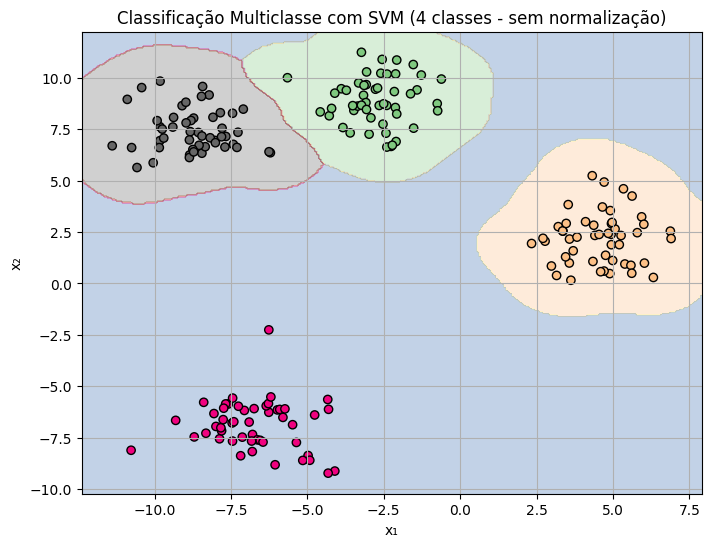

In [33]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Gerar dataset toy com 4 classes (sem normaliza√ß√£o)
X_toy_raw, y_toy_raw = make_blobs(n_samples=200, centers=4, cluster_std=1.2, random_state=42)

# Treinar modelo multiclasse
modelo = treinar_svm_multiclasse(X_toy_raw, y_toy_raw, C=1.0, kernel_fn=rbf_kernel)

# Gerar grade de pontos
xx, yy = np.meshgrid(np.linspace(X_toy_raw[:, 0].min()-1, X_toy_raw[:, 0].max()+1, 300),
                     np.linspace(X_toy_raw[:, 1].min()-1, X_toy_raw[:, 1].max()+1, 300))
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = modelo(grid_points)
Z = Z.reshape(xx.shape)

# Visualizar
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Accent')
plt.scatter(X_toy_raw[:, 0], X_toy_raw[:, 1], c=y_toy_raw, cmap='Accent', edgecolors='k')
plt.title("Classifica√ß√£o Multiclasse com SVM (4 classes - sem normaliza√ß√£o)")
plt.xlabel("x‚ÇÅ")
plt.ylabel("x‚ÇÇ")
plt.grid(True)
plt.show()
